<a href="https://colab.research.google.com/github/zots0127/Colabs/blob/main/thickness_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget bojun.wang/history.zip
!mkdir data
!mv history.zip data/history.zip
%cd data
!unzip history.zip
!rm history.zip
%cd ..

--2023-05-22 15:52:24--  http://bojun.wang/history.zip
Resolving bojun.wang (bojun.wang)... 193.123.234.57
Connecting to bojun.wang (bojun.wang)|193.123.234.57|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bojun.wang/history.zip [following]
--2023-05-22 15:52:25--  https://bojun.wang/history.zip
Connecting to bojun.wang (bojun.wang)|193.123.234.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20737041 (20M) [application/zip]
Saving to: ‘history.zip’

history.zip         100%[===================>]  19.78M  7.97MB/s    in 2.5s    

2023-05-22 15:52:28 (7.97 MB/s) - ‘history.zip’ saved [20737041/20737041]

/content/data
Archive:  history.zip
 extracting: R151.3_G150.4_B115.6_98.png  
 extracting: R153.0_G150.4_B112.7_98.png  
 extracting: R153.3_G150.5_B110.7_98.png  
 extracting: R153.4_G144.3_B105.0_107.png  
 extracting: R155.1_G144.4_B104.6_107.png  
 extracting: R159.4_G154.7_B111.2_100.png  
 extracting:

In [ ]:
import os
import re
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


class SolarCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGBA")
        image = Image.fromarray(np.array(image)[:, :, :3], mode="RGB")
        label = float(re.findall(r"_([\d.]+).png", self.image_files[idx])[0])
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
dataset = SolarCellDataset(root_dir="data", transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation on the output layer
        return x

model = ConvNet()


# Check for CUDA availability and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
def combined_loss(outputs, labels):
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    loss1 = mse_loss(outputs, labels)
    loss2 = l1_loss(outputs, labels)
    return 0.7 * loss1 + 0.3 * loss2

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

# Use TensorBoard
writer = SummaryWriter()

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # Move inputs and labels to GPU
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = combined_loss(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item()}")
    writer.add_scalar("Loss/train", running_loss, epoch)
    scheduler.step()

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # Move images and labels to GPU
        outputs = model(images)
        loss = combined_loss(outputs.view(-1), labels)
        test_loss += loss.item()
    writer.add_scalar("Loss/test", test_loss, epoch)

# Save the model
torch.save(model.state_dict(), "solar_cell_thickness_model.pth")


writer.close()


Epoch: 1, Batch: 1, Loss: 8577.0625
Epoch: 1, Batch: 2, Loss: 8110.53759765625
Epoch: 1, Batch: 3, Loss: 7265.45263671875
Epoch: 1, Batch: 4, Loss: 6230.61083984375
Epoch: 1, Batch: 5, Loss: 4858.16650390625
Epoch: 1, Batch: 6, Loss: 2842.208251953125
Epoch: 1, Batch: 7, Loss: 988.5679931640625
Epoch: 2, Batch: 1, Loss: 30.04007911682129
Epoch: 2, Batch: 2, Loss: 1338.1231689453125
Epoch: 2, Batch: 3, Loss: 2175.994873046875
Epoch: 2, Batch: 4, Loss: 1523.466796875
Epoch: 2, Batch: 5, Loss: 329.1969299316406
Epoch: 2, Batch: 6, Loss: 32.49542236328125
Epoch: 2, Batch: 7, Loss: 193.01882934570312
Epoch: 3, Batch: 1, Loss: 707.9326782226562
Epoch: 3, Batch: 2, Loss: 774.0413818359375
Epoch: 3, Batch: 3, Loss: 999.3955078125
Epoch: 3, Batch: 4, Loss: 866.2036743164062
Epoch: 3, Batch: 5, Loss: 733.2509765625
Epoch: 3, Batch: 6, Loss: 375.3910827636719
Epoch: 3, Batch: 7, Loss: 204.0279998779297
Epoch: 4, Batch: 1, Loss: 50.8336067199707
Epoch: 4, Batch: 2, Loss: 150.92874145507812
Epoch: 

NameError: ignored

In [ ]:
import os
import re
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from autoPyTorch import AutoNetRegression

# Custom dataset
class SolarCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGBA")
        image = Image.fromarray(np.array(image)[:, :, :3], mode="RGB")
        label = float(re.findall(r"_([\d.]+).png", self.image_files[idx])[0])
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = SolarCellDataset(root_dir="data", transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

# Convert data to numpy arrays for Auto-PyTorch
X_train = np.array([data[0].numpy() for data in train_dataset])
y_train = np.array([data[1] for data in train_dataset])
X_test = np.array([data[0].numpy() for data in test_dataset])
y_test = np.array([data[1] for data in test_dataset])

# Initialize Auto-PyTorch
autonet = AutoNetRegression("tiny_cs",  # config preset
                            max_runtime=300,  # max time in seconds
                            min_budget=30,  # minimum budget per algorithm
                            max_budget=90)  # maximum budget per algorithm

# Train model
autonet.fit(X_train, y_train, validation_split=0.2)

# Evaluate model
print(autonet.score(X_test, y_test))

ImportError: ignored

In [ ]:
import os
import re
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Custom dataset
class SolarCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGBA")
        image = Image.fromarray(np.array(image)[:, :, :3], mode="RGB")
        label = float(re.findall(r"_([\d.]+).png", self.image_files[idx])[0])
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = SolarCellDataset(root_dir="data", transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8)

# Custom 3-4 layer model

class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 1024)  # 32*32 is the size of the image, and 3 is for color channels
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)  # Output layer for regression

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function because it's for regression
        return x

model = FullyConnectedNet()


# Check for CUDA availability and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
def combined_loss(outputs, labels):
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()
    loss1 = mse_loss(outputs, labels)
    loss2 = l1_loss(outputs, labels)
    return 0.7 * loss1 + 0.3 * loss2

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

# Use TensorBoard
writer = SummaryWriter()

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device) # Move inputs and labels to GPU
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = combined_loss(outputs.view(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item()}")
    writer.add_scalar("Loss/train", running_loss, epoch)
    scheduler.step()

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device) # Move images and labels to GPU
        outputs = model(images)
        loss = combined_loss(outputs.view(-1), labels)
        test_loss += loss.item()
    writer.add_scalar("Loss/test", test_loss, epoch)

# Save the model
torch.save(model.state_dict(), "solar_cell_thickness_model.pth")


writer.close()




Epoch: 1, Batch: 1, Loss: 8113.76171875
Epoch: 1, Batch: 2, Loss: 7932.6005859375
Epoch: 1, Batch: 3, Loss: 7246.32470703125
Epoch: 1, Batch: 4, Loss: 6411.10205078125
Epoch: 1, Batch: 5, Loss: 5005.25830078125
Epoch: 1, Batch: 6, Loss: 3161.721435546875
Epoch: 1, Batch: 7, Loss: 1083.428466796875
Epoch: 2, Batch: 1, Loss: 39.451515197753906
Epoch: 2, Batch: 2, Loss: 1484.818603515625
Epoch: 2, Batch: 3, Loss: 2143.263916015625
Epoch: 2, Batch: 4, Loss: 1129.968994140625
Epoch: 2, Batch: 5, Loss: 297.88116455078125
Epoch: 2, Batch: 6, Loss: 48.19647216796875
Epoch: 2, Batch: 7, Loss: 307.9728088378906
Epoch: 3, Batch: 1, Loss: 531.6257934570312
Epoch: 3, Batch: 2, Loss: 752.440673828125
Epoch: 3, Batch: 3, Loss: 871.2545776367188
Epoch: 3, Batch: 4, Loss: 746.554931640625
Epoch: 3, Batch: 5, Loss: 465.5716552734375
Epoch: 3, Batch: 6, Loss: 260.9583435058594
Epoch: 3, Batch: 7, Loss: 126.87648010253906
Epoch: 4, Batch: 1, Loss: 46.863712310791016
Epoch: 4, Batch: 2, Loss: 208.191589355

KeyboardInterrupt: ignored

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


# Create a results directory if it doesn't exist
if not os.path.exists("results"):
    os.makedirs("results")

# Define the image transformation
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

# Initialize lists to store true and predicted thickness values
true_thicknesses = []
predicted_thicknesses = []

# Sort the test dataset by true thickness
sorted_test_dataset = sorted(test_dataset, key=lambda x: x[1])

# Iterate through the sorted test dataset
for i, data in enumerate(sorted_test_dataset, 0):
    image, true_thickness = data
    image = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    # Predict the thickness using the model
    input_image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_thickness = model(input_image).item()

    # Append the true and predicted thickness values to the lists
    true_thicknesses.append(true_thickness)
    predicted_thicknesses.append(predicted_thickness)

# Plot the true and predicted thickness values as a scatter plot
plt.scatter(range(len(true_thicknesses)), true_thicknesses, color='red', label='True')
plt.scatter(range(len(predicted_thicknesses)), predicted_thicknesses, color='green', label='Predicted')
plt.xlabel('Sorted Test Image Index')
plt.ylabel('Thickness')
plt.legend()
plt.show()


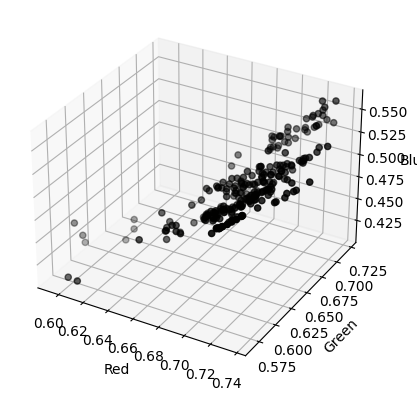

In [ ]:
import os
import re
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

# Custom dataset
class SolarCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert("RGBA")
        image = Image.fromarray(np.array(image)[:, :, :3], mode="RGB")
        label = float(re.findall(r"_([\d.]+).png", self.image_files[idx])[0])
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
dataset = SolarCellDataset(root_dir="data", transform=transform)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Initialize empty list to hold RGB values
rgb_values = []

# Calculate average RGB values for each image in the dataset
for image, label in dataset:
    # Convert tensor to numpy array and compute mean RGB values
    numpy_image = image.numpy()
    mean_rgb = np.mean(numpy_image, axis=(1, 2))
    rgb_values.append(mean_rgb)

# Convert list to numpy array
rgb_values = np.array(rgb_values)

# Plot 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rgb_values[:, 0], rgb_values[:, 1], rgb_values[:, 2], c=rgb_values / 255.0)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
plt.show()


In [ ]:
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_values[:, 0],
    y=rgb_values[:, 1],
    z=rgb_values[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=rgb_values,  # set color to RGB values
        colorscale='Viridis',  # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='Red',
    yaxis_title='Green',
    zaxis_title='Blue'))

# Save as HTML
fig.write_html("thickness.html")

In [ ]:
# Initialize empty list to hold RGB values and labels
rgb_values = []
labels = []

# Calculate average RGB values for each image in the dataset
for image, label in dataset:
    # Convert tensor to numpy array and compute mean RGB values
    numpy_image = image.numpy()
    mean_rgb = np.mean(numpy_image, axis=(1, 2))
    rgb_values.append(mean_rgb)
    labels.append(label)

# Convert list to numpy array
rgb_values = np.array(rgb_values)
labels = np.array(labels)

# Normalize labels to range 0-255
normalized_labels = 255 * (labels - labels.min()) / (labels.max() - labels.min())

# Create a new color array with RGB values, where blue is determined by the label
colors = np.zeros((len(labels), 3))
colors[:, 0:2] = rgb_values[:, 0:2]  # Keep the original Red and Green values
colors[:, 2] = normalized_labels  # Set Blue values based on labels

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_values[:, 0],
    y=rgb_values[:, 1],
    z=rgb_values[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=colors,  # set color to RGB values
        colorscale='Viridis',  # choose a colorscale
        opacity=0.8
    )
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='Red',
    yaxis_title='Green',
    zaxis_title='Blue'))

# Save as HTML
fig.write_html("thickness1.html")


In [ ]:
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_values[:, 0],
    y=rgb_values[:, 1],
    z=rgb_values[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=colors,  # set color to RGB values
        colorscale='Viridis',  # choose a colorscale
        opacity=0.8
    ),
    text=labels,  # add labels as hover text
    hoverinfo='text'
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='Red',
    yaxis_title='Green',
    zaxis_title='Blue'))

# Save as HTML
fig.write_html("1thickness.html")


In [ ]:
# Normalize labels to range 0-1
normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_values[:, 0],
    y=rgb_values[:, 1],
    z=rgb_values[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=normalized_labels,  # set color to normalized labels
        colorscale='Rainbow',  # choose a colorscale
        opacity=0.8,
        colorbar=dict(title='Labels')  # add colorbar
    ),
    text=labels,  # add labels as hover text
    hoverinfo='text'
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='Red',
    yaxis_title='Green',
    zaxis_title='Blue'))

# Save as HTML
fig.write_html("rthickness.html")


In [ ]:
# Assemble matrix A and vector b
A = np.c_[rgb_values[:, 0], rgb_values[:, 1], np.ones(rgb_values.shape[0])]
b = rgb_values[:, 2]

# Solve for plane parameters (a, b, c) in ax + by + c = z
coeff, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

# Create a grid of points
xx, yy = np.meshgrid(range(int(rgb_values[:, 0].min()), int(rgb_values[:, 0].max())),
                     range(int(rgb_values[:, 1].min()), int(rgb_values[:, 1].max())))

# Calculate corresponding z
zz = coeff[0] * xx + coeff[1] * yy + coeff[2]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_values[:, 0],
    y=rgb_values[:, 1],
    z=rgb_values[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=normalized_labels,  # set color to normalized labels
        colorscale='Rainbow',  # choose a colorscale
        opacity=0.8,
        colorbar=dict(title='Labels')  # add colorbar
    ),
    text=labels,  # add labels as hover text
    hoverinfo='text'
)])

# Add the plane
fig.add_trace(go.Surface(x=xx, y=yy, z=zz, colorscale='Greys', opacity=0.5))

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='Red',
    yaxis_title='Green',
    zaxis_title='Blue'))

# Save as HTML
fig.write_html("cthickness.html")
